Import libraries

In [20]:
import os
import fitsio as ft
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import logging 
from scipy.optimize import curve_fit, minimize
import scipy.special as sp
import sys
sys.path.append("/global/homes/a/arosado/photometry/")
from photometry import Catalogue, HealpixDensity, TargetSelection, utils, setup_logging

logger = logging.getLogger('DA02')
setup_logging()

plot_dir = 'plots_fits'

# Class

In [21]:
def get_legacysim_data(z_col='INPUT_HSC_MIZUKI_PHOTOZ_BEST', zmin=0.6,zmax=1.6,region='south'):
        test_dir = '/global/cscratch1/sd/arosado/legacysim_fitting'

        # legacysim data
        legacysim = ft.read(f'{test_dir}/legacysim_data_{region}.fits')
        z = legacysim[z_col]
        depth = legacysim['GALDEPTH_R']
        mask = z>zmin
        mask &= z<zmax
        mask &= depth > 0
        legacysim = legacysim[mask]
       
        return legacysim
    
def get_ELG_data_old(zmin=0.6,zmax=1.6,region='south'):
        r = region.capitalize()[0]
        test_dir = '/global/cscratch1/sd/arosado/legacysim_fitting'
        base_dir = '/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/'
    
        data_full = ft.read(f'{test_dir}/data_{region}.fits')
        data_full = data_full[data_full['PHOTSYS'] == r]
        data_clustering = Catalogue.load(os.path.join(base_dir, f'ELG_LOPnotqsozdone_{r}_clustering.dat.fits'))
        ind1, ind2 = utils.overlap(data_clustering['TARGETID'], data_full['TARGETID'])
        cat = data_clustering[ind1]
        z = cat['Z']
        depth = data_full['GALDEPTH_R'][ind2]
        
        mask = z>zmin
        mask &= z<zmax
        mask &= depth > 0
        cat = cat[mask]
        depth = depth[mask]
        cat.columns['GALDEPTH_R'] = depth
        
        return cat
    
def get_ELG_data(zmin=0.6,zmax=1.6,region='south'):
        r = region.capitalize()[0]
        #full_dir = '/global/cscratch1/sd/arosado/catalogs/edav1/da02/'
        base_dir = '/global/cscratch1/sd/arosado/catalogs/DA02/LSS/guadalupe/LSScats/test/'
    
        data_full = ft.read(os.path.join(base_dir,'ELG_LOPnotqso_full.dat.fits'))
        data_full = data_full[data_full['PHOTSYS'] == r]
        data_clustering = Catalogue.load(os.path.join(base_dir, f'ELG_LOPnotqso_{r}_clustering.dat.fits'))
        ind1, ind2 = utils.overlap(data_clustering['TARGETID'], data_full['TARGETID'])
        cat = data_clustering[ind1]
        z = cat['Z']
        depth = data_full['GALDEPTH_R'][ind2]
        
        #mask = z>zmin
        #mask &= z<zmax
        #mask = depth > 0
        #print(f"removed {cat['RA'].size - cat[mask]['RA'].size} objects with zcut")
        #cat = cat[mask]
        #depth = depth[mask]
        cat.columns['GALDEPTH_R'] = depth
        
        return cat
    
class ELG_dndz:
    def __init__(self, zmin=0.6, zmax=1.6, bins=50,run='south'):
        self.region = run[0].upper()
        test_dir = '/global/cscratch1/sd/arosado/legacysim_fitting'
        
        # legacysim data
        z_col = 'INPUT_HSC_MIZUKI_PHOTOZ_BEST'
        self.legacysim = get_legacysim_data(z_col=z_col,zmin=zmin,zmax=zmax,region=run)
        self.z = self.legacysim[z_col]
        self.depth = self.legacysim['GALDEPTH_R']
        self.weights = None

        # ELG data
        self.cat = get_ELG_data(zmin=zmin,zmax=zmax,region=run)
        self.z_cat = self.cat['Z']
        self.depth_cat = self.cat['GALDEPTH_R']
        #self.weights_cat = self.cat['WEIGHT_COMP']*self.cat['WEIGHT_FKP']*self.cat['WEIGHT_RF'] # for old cat
        self.weights_cat = self.cat['WEIGHT'] #self.cat['WEIGHT_COMP']*self.cat['WEIGHT_SYS']

        # redshif bins
        self.bins = bins+1
        self.zbins = np.linspace(zmin, zmax, self.bins)
        self.bc = (self.zbins[:-1] + self.zbins[1:])/2.

        self.quantiles = np.quantile(self.depth, q=np.linspace(0., 1., 6))
        self.labels = ['{:.0f} < {} < {:.0f}'.format(low, 'depth_r', high) for low, high in zip(self.quantiles[:-1], self.quantiles[1:])]
        self.samples = np.clip(np.digitize(self.depth, self.quantiles) - 1, 0, len(self.quantiles) - 1)
        self.usamples = np.unique(self.samples)
        self.nsamples = len(self.usamples)-1  

        self.bin_data_dndz()
        self.new_weights = self.get_pred_weights()#*self.weights_cat
        self.residuals = self.get_residuals() # maybe find better name?
    
    def dndz_model_old(self,X, a, b, c, d, e, f, g):
        #[1.0, 1.0, 0.8, 1.0, 1.0, 0.0, 1.0]
        z_, depth_base = X
        depth_ = np.log10(depth_base)
        res = []
        for z, depth in zip(z_, depth_):
            if z < c:
                res.append((a + b*z) * (d*sp.erf(depth/e+f) + g))
            elif z >= c:
                res.append((a + b*c) * (d*sp.erf(depth/e+f) + g))
        res = np.array(res)
        return res
    
    def dndz_model(self,X, a, b, c, d, e, f, g):
        #[1.0, 1.0, 0.8, 1.0, 1.0, 0.0, 1.0]
        z_, depth_base = X
        res = []
        for z, depth in zip(z_, depth_base):
            if depth<=0:
                #print(f'depth={depth} is bad value')
                res.append(0) # no negative or 0 depth values
            elif z < c:
                depth = np.log10(depth)
                res.append((a + b*z) * (d*sp.erf(depth/e+f) + g))
            elif z >= c:
                depth = np.log10(depth)
                res.append((a + b*c) * (d*sp.erf(depth/e+f) + g))
        res = np.array(res)
        return res

    def cost(self, params):
        # get chi2 using simulated data
        dndz_pred = self.dndz_model((self.z_h, self.depth_h), *params)
        c = np.sum(((self.dndz_h - dndz_pred)/(self.yerr))**2)
        return c
    
    def test(self):
        # minimize cost function using binned simulated data
        options = {'maxfev': 4*7*200, 'maxiter': 1000}
        return minimize(self.cost,[1.0, 1.0, 0.8, 1.0, 1.0, 0.0, 1.0], method='Powell', tol=1e-6, options=options) 
                           
    def bin_data_dndz(self):
        # function to bin simulated data into 5 depth bins, each depth bin with `self.bins` number of bins
        dndzw = np.histogram(self.z, bins=self.zbins, weights=self.weights)[0]
        dndz = np.histogram(self.z, bins=self.zbins)[0]
        
        z_list = []
        depth_list = []
        dndz_list = []
        yerr_list = []

        for isample, sample in enumerate(self.usamples):
            mask = self.samples == sample
            depth_sample = np.full_like(self.bc, self.depth[mask].mean())
            
            dndzw_sample = np.histogram(self.z[mask], bins=self.zbins, weights=self.weights[mask] if self.weights is not None else None)[0]
            ratio = dndzw_sample.sum()/dndzw.sum()
            dndz_norm =  1./ratio*dndzw_sample/dndzw - 1.

            if isample < self.nsamples:
                #print(f'max depth in bin {isample}: {self.depth[mask].max()}')
                z_list.append(self.bc)
                depth_list.append(depth_sample)
                dndz_list.append(dndz_norm)
                yerr_ = 1 / np.sqrt(dndzw_sample)
                yerr_list.append(yerr_)
            
        self.z_h = np.concatenate(z_list)
        self.depth_h = np.concatenate(depth_list)
        self.dndz_h = np.concatenate(dndz_list)
        self.yerr = np.concatenate(yerr_list)
    
    def get_pred_weights(self):
        # apply fit at catalog level using optimal parameters obtained from fitting binned simulated data
        self.res = self.test()
        self.params = self.res.x
        f = self.dndz_model((self.z_cat, self.depth_cat),*self.params)
        #print(f'min depth used when calculating weights {self.depth_cat.min()}')
        #print(f'min f when calculating weights {f.min()}')
        self.dndz_vals = f
        print(f'min(dndz - 1): {f.min()}, max(dndz - 1): {f.max()}')
        w = 1/(f+1)
        return w
    
    def get_residuals(self): # maybe different name
        # apply fit to obiwan data using optimal parameters obtained from fitting binned obiwan data
        self.res = self.test()
        self.params = self.res.x
        f = self.dndz_model((self.z, self.depth),*self.params)
        self.dndz_vals_obiwan = f
        print(f'min(dndz - 1): {f.min()}, max(dndz - 1): {f.max()}')
        w = 1/(f+1)
        return w
    
    def get_chi2(self):
        #
        N,n = len(self.dndz_h), len(self.params)
        print(f'number of data points: {N}')
        print (f'number of free parameters: {n}')
        chi2 = self.res.fun / (N-n)
        print(f'reduced $\chi^2$: {chi2}')
        return chi2
        
    # below is code for visualization
    def plot_dndz(self, z, depth, weights=None, legend=False, yerr=False, ls='-'):
        ax = plt.gca()
        fig = plt.gcf()
        #fig.set_size_inches(7, 5)
        #ax.plot([], [], linestyle=ls, color='k', label='using pred weights')
        quantiles = np.quantile(depth, q=np.linspace(0., 1., 6))
        labels = ['{:.0f} < {} < {:.0f}'.format(low, 'depth_r', high) for low, high in zip(quantiles[:-1], quantiles[1:])]
        samples = np.clip(np.digitize(depth, quantiles) - 1, 0, len(quantiles) - 1)
        usamples = np.unique(samples)
        nsamples = len(usamples)-1  
        
        dndzw = np.histogram(z, bins=self.zbins, weights=weights)[0]
        dndz = np.histogram(z, bins=self.zbins)[0]
        
        z_list = []
        depth_list = []
        dndz_list = []
        yerr_list = []

        for isample, (sample, label) in enumerate(zip(usamples, labels)):
            mask = samples == sample
            depth_sample = np.full_like(self.bc, depth[mask].mean())
            dndzw_sample = np.histogram(z[mask], bins=self.zbins, weights=weights[mask] if weights is not None else None)[0]
            ratio = dndzw_sample.sum()/dndzw.sum()
            dndz_norm =  1./ratio*dndzw_sample/dndzw - 1.
            
            if isample < nsamples:
                if yerr:
                    yerr_ = 1 / np.sqrt(dndzw_sample)
                    if legend:
                        ax.errorbar(self.bc, dndz_norm, yerr=yerr_, color='C{:d}'.format(isample), ls=ls, label=label)
                    else:
                        ax.plot(self.bc, dndz_norm, color='C{:d}'.format(isample), ls=ls)
                else:
                    if legend:
                        ax.plot(self.bc, dndz_norm, color='C{:d}'.format(isample), ls=ls, label=label)
                    else:
                        ax.plot(self.bc, dndz_norm, color='C{:d}'.format(isample), ls=ls)
            
        
        #ax.set_title('Southern part of DA02 {}'.format('ELG_LOPnotqso'))
        if legend:
            ax.legend(loc=4, ncol=2)

In [22]:
run = 'north'
test = ELG_dndz(run=run)

[ 000016.10 ]: 10-19 21:36  Catalogue       INFO     Loading catalogue /global/cscratch1/sd/arosado/catalogs/DA02/LSS/guadalupe/LSScats/test/ELG_LOPnotqso_N_clustering.dat.fits.


min(dndz - 1): -0.5273907672470612, max(dndz - 1): 2.5103146890937666
min(dndz - 1): -0.4562989755065769, max(dndz - 1): 3.536693464330353


In [23]:
test.cat.columns['WEIGHT_DEPTHZ'] = test.new_weights

In [24]:
test.cat.save(f'ELG_LOPnotqso_{run.capitalize()[0]}_clustering_depthz_weights.fits', format='fits', overwrite=True)  

[ 000030.96 ]: 10-19 21:37  Catalogue       INFO     Saving catalogue to ELG_LOPnotqso_N_clustering_depthz_weights.fits.


In [25]:
test.cat.columns

{'TARGETID': array([39632930577842307, 39632930577842659, 39632930577843529, ...,
        39633456228992928, 39633456228993127, 39633456228993683]),
 'Z': array([1.02570196, 1.06725684, 0.81747725, ..., 1.02916121, 1.46447541,
        1.17780774]),
 'NTILE': array([1, 1, 1, ..., 1, 1, 1]),
 'TILES': array(['2175', '2175', '2175', ..., '1030', '1030', '1030'], dtype='<U9'),
 'RA': array([184.4407741 , 184.46741098, 184.52963593, ..., 258.56636283,
        258.59892713, 258.67856617]),
 'DEC': array([32.60892598, 32.58811598, 32.52082506, ..., 66.19710406,
        66.23315155, 66.20069843]),
 'WEIGHT': array([3.20484378, 4.29344944, 3.19242775, ..., 1.25921283, 3.76431122,
        1.23608596]),
 'WEIGHT_ZFAIL': array([1.02329563, 1.02816277, 1.01933124, ..., 1.01342516, 1.00984986,
        1.0091494 ]),
 'WEIGHT_COMP': array([3., 4., 3., ..., 1., 3., 1.]),
 'WEIGHT_SYS': array([1.04396151, 1.04396151, 1.04396151, ..., 1.24253164, 1.24253164,
        1.22487905]),
 'NZ': array([0.00070235

In [18]:
from astropy.table import Table 
Table.read(f'ELG_LOPnotqso_{run.capitalize()[0]}_depthz_weights.fits')

TARGETID,Z,NTILE,TILES,RA,DEC,WEIGHT,WEIGHT_ZFAIL,WEIGHT_COMP,WEIGHT_SYS,NZ,WEIGHT_FKP,GALDEPTH_R,WEIGHT_DEPTHZ
int64,float64,int64,bytes9,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64
39627507795756387,0.8095998200486286,1,1295,311.65677901428234,-11.663368159079912,1.9647102074317646,1.0264428918723245,2.0,0.9570479872718276,0.0006025781698473827,0.6059856551440109,116.90359,0.8724473201716357
39627507799950999,0.7860788884238721,1,1295,311.9127665301777,-11.637681322022628,7.900276292331505,1.028216124934269,7.0,1.097639758350074,0.000523113093315961,0.639198872339288,121.15347,0.7558420660915992
39627507804143686,1.1788113094480637,1,1295,312.06957032108664,-11.645834390338331,4.08871370526926,1.031977122304815,4.0,0.9905049290573267,0.0005787895371556628,0.6155606594129147,252.26122,1.0105905350163187
39627507804147324,0.6015973058580344,1,1295,312.2287443413245,-11.625146141319432,1.066150905107625,1.03477115240007,1.0,1.0303253068417806,5.3333403463134375e-05,0.9455829224047844,122.09994,0.3640933586167987
39627513705531559,0.7375673451243747,1,1295,310.86702951565644,-11.39453987936898,2.15461169947452,1.0346858933814895,2.0,1.041191202690976,0.0003092306026242767,0.7498099811797957,385.26288,1.082147505852701
39627513705532053,0.7053087955428645,1,1295,310.8834886310963,-11.443133732176728,4.331512232484595,1.0400376562176403,4.0,1.041191202690976,0.00024069896886165867,0.7938252659368022,385.26288,1.1150508600420337
39627513709726336,0.9476519583314276,1,1295,311.1327524437879,-11.382109360884865,3.1228097144081026,1.0284838569201498,3.0,1.0121078366621212,0.000735205721372547,0.5576267980668079,353.57373,0.995922099627756
39627513709727195,1.0091889283871878,1,1295,311.15965480907545,-11.3786116622662,2.1243810280768507,1.0494835387713963,2.0,1.0121078366621212,0.0007283542186636501,0.5599351578720466,353.57373,0.995922099627756
39627513713923193,1.4960152534387072,1,1295,311.4718022296949,-11.394804560705248,3.3543379333368106,1.01831972879777,3.0,1.097997625721785,0.00035228691904608657,0.7245691178703619,589.363,0.9837921441988009


# South

[ 000059.15 ]: 10-19 13:44  Catalogue       INFO     Loading catalogue /global/cscratch1/sd/arosado/catalogs/DA02/LSS/guadalupe/LSScats/test/ELG_LOPnotqso_S_clustering.dat.fits.


min(dndz - 1): -0.5888101148780751, max(dndz - 1): 3.835820911047162
min(dndz - 1): -0.6152129530840917, max(dndz - 1): 3.847152474695214
226.88697651814672
[ -0.77948942   0.94212811   0.83553054 -18.41448467  -0.66934513
   2.76041267 -15.32798643]


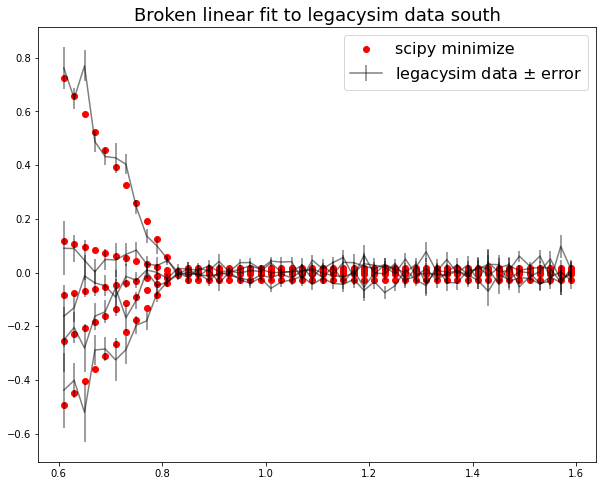

CPU times: user 14.9 s, sys: 3.08 s, total: 17.9 s
Wall time: 17.7 s


In [5]:
%%time
# Here we look at the effect of using yerr when fitting 

fig = plt.figure(figsize=(10,8))

run = 'south'
test = ELG_dndz(run=run)
print(test.res.fun)
#test.get_chi2()
params = test.params
print(params)
dndz = test.dndz_model((test.z_h, test.depth_h),*params)
plt.scatter(test.z_h, dndz, color='red', label='scipy minimize')

bins=test.bins-1
kw= dict(color='k', alpha=0.5)
plt.errorbar([],[],yerr=[], label=f'legacysim data $\pm$ error',**kw)
for ite in range(10):
    i, j = (bins)*ite, (bins)*(ite+1)
    plt.errorbar(test.z_h[i:j], test.dndz_h[i:j], yerr=test.yerr[i:j], **kw)
    #plt.plot(test.z_h[i:j], (test.dndz_h[i:j]+1)/(dndz_err+1), yerr=test.yerr[i:j], **kw)
plt.legend(fontsize=16)
plt.title(f'Broken linear fit to legacysim data {run}', fontsize=18)
#plt.savefig(f'{plot_dir}/fit_legacysim_data_{run}.png', bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor='white')
plt.show()
#print(test.pred_weights.min(), test.pred_weights.max())

In [8]:
test.new_weights[np.where(test.new_weights==1.)[0]].size

26

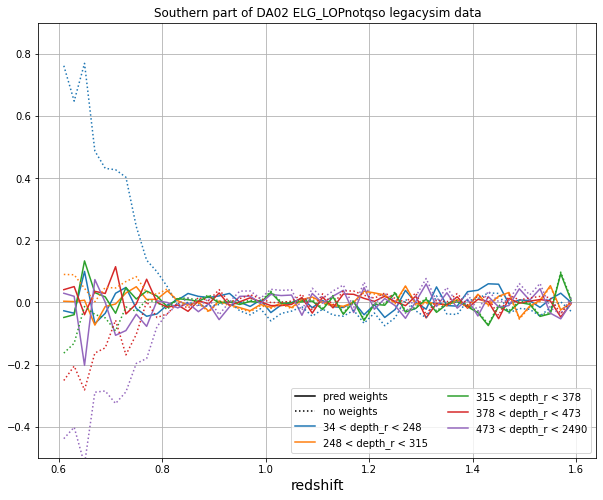

In [9]:
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
#fig = plt.gcf()
#fig.set_size_inches(7, 5)
ax.set_title('Southern part of DA02 {}'.format('ELG_LOPnotqso')+' legacysim data')#, fontsize=18)

ax.plot([], [], linestyle='-', color='k', label='pred weights')
ax.plot([], [], linestyle=':', color='k', label='no weights')

test.plot_dndz(test.z, test.depth, weights=test.residuals, ls='-', legend=True)
plt.xlabel('redshift', fontsize=14)
plt.ylim(-0.5,0.9)
test.plot_dndz(test.z, test.depth, weights=None, ls=':')
ax.grid(True)
#plt.savefig(f'{plot_dir}/ELG_data_{run}_RF.png', bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor='white')
plt.show()

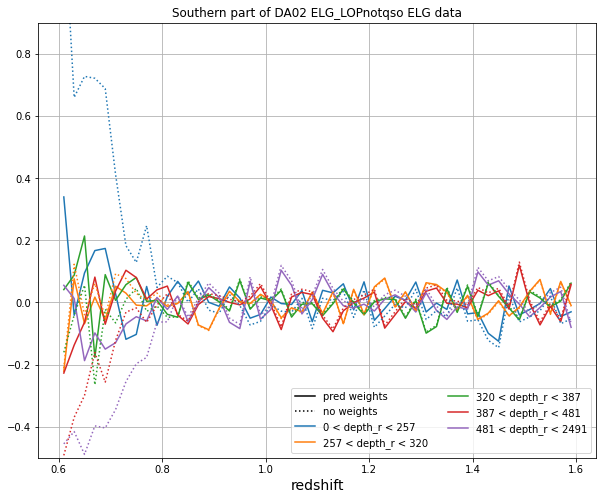

In [10]:
# Here we see effect of using dndz model with optimal parameters obtained from legacysim data
# on real ELG data (not legacysim/obiwan data) and using the result to get the predicted weights
#test = ELG_dndz(run='south')
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
#fig = plt.gcf()
#fig.set_size_inches(7, 5)
ax.set_title('Southern part of DA02 {}'.format('ELG_LOPnotqso')+' ELG data')#, fontsize=18)

ax.plot([], [], linestyle='-', color='k', label='pred weights')
ax.plot([], [], linestyle=':', color='k', label='no weights')

test.plot_dndz(test.z_cat, test.depth_cat, weights=test.new_weights*test.weights_cat, ls='-', legend=True)#, yerr=True)
plt.xlabel('redshift', fontsize=14)
plt.ylim(-0.5,0.9)
test.plot_dndz(test.z_cat, test.depth_cat, weights=test.weights_cat, ls=':')
ax.grid(True)
#plt.savefig(f'{plot_dir}/ELG_data_{run}_RF.png', bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor='white')
plt.show()

In [11]:
wmin, wmax = 0.5, 2.0 # min and max weight
print(f'total: {test.new_weights.size}')
print(f'weight less than {wmin}: {test.new_weights[test.new_weights < wmin].size}')
print(f'{test.new_weights[test.new_weights < wmin].size/test.new_weights.size*100:.3f}%')
print(f'weight greater than {wmax}: {test.new_weights[test.new_weights > wmax].size}')
print(f'{test.new_weights[test.new_weights > wmax].size/test.new_weights.size*100:.3f}%')

total: 126043
weight less than 0.5: 161
0.128%
weight greater than 2.0: 2
0.002%


In [12]:
dmin, dmax = -1.0, 1.0 # min and max [dndz - 1]
print(f'total: {test.dndz_vals.size}')
print(f'[dndz - 1] less than {dmin}: {test.dndz_vals[test.dndz_vals < dmin].size}')
print(f'{test.dndz_vals[test.dndz_vals < dmin].size/test.dndz_vals.size*100:.3f}%')
print(f'[dndz - 1] greater than {dmax}: {test.dndz_vals[test.dndz_vals > dmax].size}')
print(f'{test.dndz_vals[test.dndz_vals > dmax].size/test.dndz_vals.size*100:.3f}%')

total: 126043
[dndz - 1] less than -1.0: 0
0.000%
[dndz - 1] greater than 1.0: 161
0.128%


In [10]:
126451/47865

2.6418259688707826

[ -0.77948942   0.94212811   0.83553054 -18.41448467  -0.66934513
   2.76041267 -15.32798643]
[1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2
 3.3 3.4]


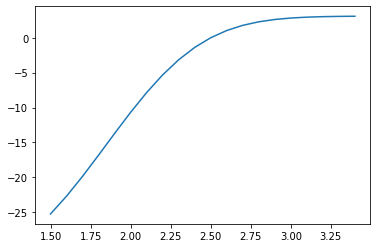

In [15]:
# function used to model depth dependence portion
a,b,c,d,e,f,g = test.params
print(test.params)
depth = np.arange(1.5,3.5,0.1)
print(depth)
fun = (d*sp.erf(depth/e+f) + g) 
plt.plot(depth, fun)
plt.show()

/tmp/ipykernel_32693/610146615.py:3: RuntimeWarning: divide by zero encountered in log10
  sc = plt.scatter(test.z_cat,np.log10(test.depth_cat),c=test.new_weights, s=1)


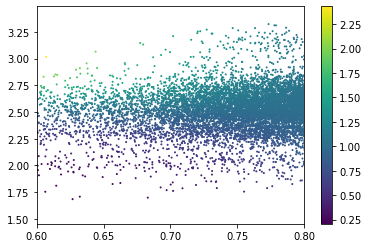

In [16]:
# Here we see how weights increase with increasing depth
#fig = plt.figure(figsize=(10,8))
sc = plt.scatter(test.z_cat,np.log10(test.depth_cat),c=test.new_weights, s=1)
plt.xlim(0.6,0.8)
plt.colorbar(sc)
plt.show()

## North

min(dndz - 1): -0.4451615825744787, max(dndz - 1): 2.5103146890937666
min(dndz - 1): -0.4562989755065769, max(dndz - 1): 3.536693464330353
264.2844153815325
[ -0.96615876   1.18454155   0.82466143 -18.60946888  -0.97549129
   1.2729077  -15.28964207]


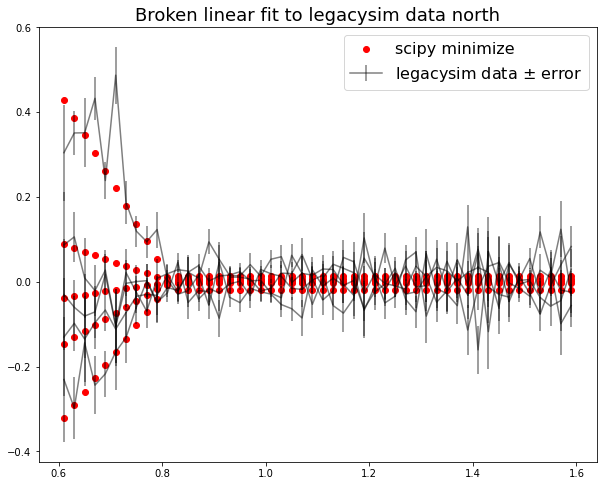

CPU times: user 9.65 s, sys: 664 ms, total: 10.3 s
Wall time: 10.4 s


In [13]:
%%time
# Here we look at the effect of using yerr when fitting 

fig = plt.figure(figsize=(10,8))

run = 'north'
test = ELG_dndz(run=run)
print(test.res.fun)
#test.get_chi2()
params = test.params
print(params)
dndz = test.dndz_model((test.z_h, test.depth_h),*params)
plt.scatter(test.z_h, dndz, color='red', label='scipy minimize')

bins=test.bins-1
kw= dict(color='k', alpha=0.5)
plt.errorbar([],[],yerr=[], label=f'legacysim data $\pm$ error',**kw)
for ite in range(10):
    i, j = (bins)*ite, (bins)*(ite+1)
    plt.errorbar(test.z_h[i:j], test.dndz_h[i:j], yerr=test.yerr[i:j], **kw)
    #plt.plot(test.z_h[i:j], (test.dndz_h[i:j]+1)/(dndz_err+1), yerr=test.yerr[i:j], **kw)
plt.legend(fontsize=16)
plt.title(f'Broken linear fit to legacysim data {run}', fontsize=18)
#plt.savefig(f'{plot_dir}/fit_legacysim_data_{run}.png', bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor='white')
plt.show()
#print(test.pred_weights.min(), test.pred_weights.max())

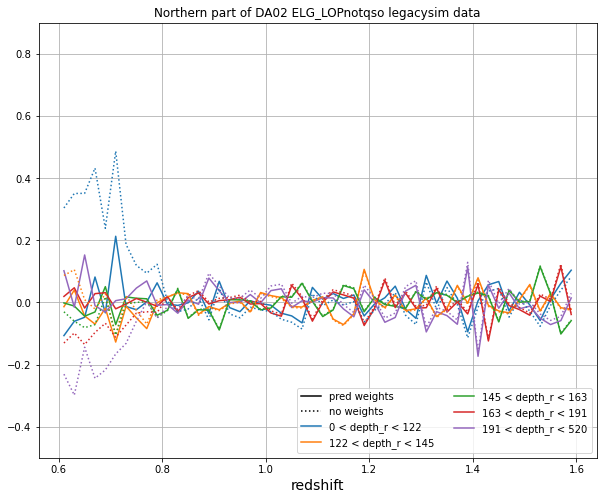

In [14]:
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
#fig = plt.gcf()
#fig.set_size_inches(7, 5)
ax.set_title('Northern part of DA02 {}'.format('ELG_LOPnotqso')+' legacysim data')#, fontsize=18)

ax.plot([], [], linestyle='-', color='k', label='pred weights')
ax.plot([], [], linestyle=':', color='k', label='no weights')

test.plot_dndz(test.z, test.depth, weights=test.residuals, ls='-', legend=True)
plt.xlabel('redshift', fontsize=14)
plt.ylim(-0.5,0.9)
test.plot_dndz(test.z, test.depth, weights=None, ls=':')
ax.grid(True)
#plt.savefig(f'{plot_dir}/ELG_data_{run}_RF.png', bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor='white')
plt.show()

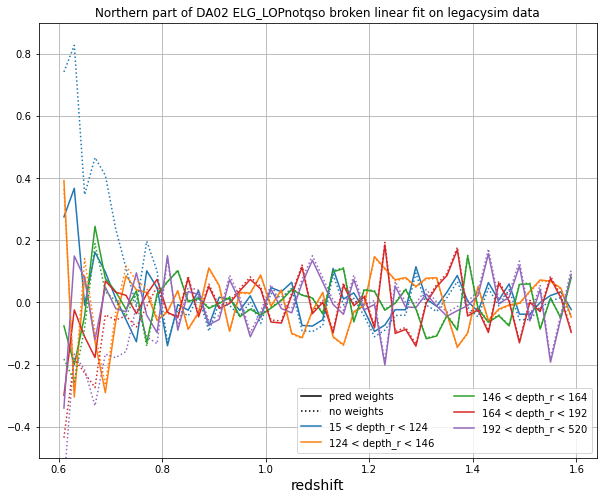

In [15]:
# Here we see effect of using dndz model with optimal parameters obtained from legacysim data
# on real ELG data (not legacysim/obiwan data) and using the result to get the predicted weights
#test = ELG_dndz(run='south')
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
#fig = plt.gcf()
#fig.set_size_inches(7, 5)
ax.set_title('Northern part of DA02 {}'.format('ELG_LOPnotqso')+' broken linear fit on legacysim data')#, fontsize=18)

ax.plot([], [], linestyle='-', color='k', label='pred weights')
ax.plot([], [], linestyle=':', color='k', label='no weights')

test.plot_dndz(test.z_cat, test.depth_cat, weights=test.new_weights*test.weights_cat, ls='-', legend=True)
plt.xlabel('redshift', fontsize=14)
plt.ylim(-0.5,0.9)
test.plot_dndz(test.z_cat, test.depth_cat, weights=test.weights_cat, ls=':')
ax.grid(True)
#plt.savefig(f'{plot_dir}/ELG_data_{run}.png', bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor='white')
plt.show()

In [16]:
wmin, wmax = 0.5, 2.0 # min and max weight
print(f'total: {test.new_weights.size}')
print(f'weight less than {wmin}: {test.new_weights[test.new_weights < wmin].size}')
print(f'{test.new_weights[test.new_weights < wmin].size/test.new_weights.size*100:.3f}%')
print(f'weight greater than {wmax}: {test.new_weights[test.new_weights > wmax].size}')
print(f'{test.new_weights[test.new_weights > wmax].size/test.new_weights.size*100:.3f}%')

total: 47865
weight less than 0.5: 13
0.027%
weight greater than 2.0: 0
0.000%


In [17]:
dmin, dmax = -1.0, 1.0 # min and max [dndz - 1]
print(f'total: {test.dndz_vals.size}')
print(f'[dndz - 1] less than {dmin}: {test.dndz_vals[test.dndz_vals < dmin].size}')
print(f'{test.dndz_vals[test.dndz_vals < dmin].size/test.dndz_vals.size*100:.3f}%')
print(f'[dndz - 1] greater than {dmax}: {test.dndz_vals[test.dndz_vals > dmax].size}')
print(f'{test.dndz_vals[test.dndz_vals > dmax].size/test.dndz_vals.size*100:.3f}%')

total: 47865
[dndz - 1] less than -1.0: 0
0.000%
[dndz - 1] greater than 1.0: 13
0.027%


[ -0.96615876   1.18454155   0.82466143 -18.60946888  -0.97549129
   1.2729077  -15.28964207]
[1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2
 3.3 3.4]


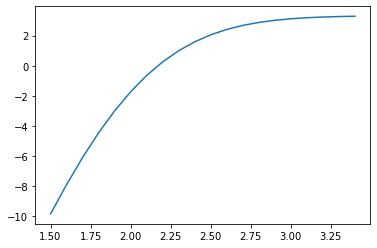

In [ ]:
# function used to model depth dependence portion
a,b,c,d,e,f,g = test.params
print(test.params)
depth = np.arange(1.5,3.5,0.1)
print(depth)
fun = (d*sp.erf(depth/e+f) + g) 
plt.plot(depth, fun)
plt.show()

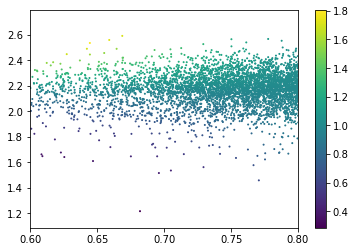

In [ ]:
# Here we see how weights increase with increasing depth
#fig = plt.figure(figsize=(10,8))
sc = plt.scatter(test.z_cat,np.log10(test.depth_cat),c=test.new_weights, s=1)
plt.xlim(0.6,0.8)
plt.colorbar(sc)
plt.show()

In [ ]:
def get_ELG_randoms(zmin=0.6,zmax=1.6,region='south',ind=0):
        test_dir = '/global/cscratch1/sd/arosado/legacysim_fitting'
        base_dir = '/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/'
    
        ran_full,h = ft.read(f'{test_dir}/legacysim_randoms_{region}.fits', header=True)
        print(h)
        ran_clustering = Catalogue.load(os.path.join(base_dir, f"'ELG_LOPnotqsozdone_{ind}_clustering.ran.fits"))
        #print(ran_clustering.columns)
        ind1, ind2 = utils.overlap(ran_clustering['TARGETID'], ran_full['TARGETID'])
        cat = ran_clustering[ind1]
        z = cat['Z']
        depth = ran_full['GALDEPTH_R'][ind2]
        
        mask = z>zmin
        mask &= z<zmax
        cat = cat[mask]
        
        return cat
    
c = get_ELG_randoms(ind=0)

# Mean Density

In [3]:
import sys
sys.path.append('/global/homes/a/arosado/LSSutils/')

from lssutils.lab import get_meandensity

[ 000005.09 ]: 10-06 12:22  numexpr.utils   INFO     Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [4]:
import sys
sys.path.append("/global/homes/a/arosado/")
from prepare_data import prepare_data, maps_dr9m, maps_dr9
from astropy.table import Table, vstack

In [5]:
def radec2hpix(nside, ra, dec):
    """ change ra,dec to HEALPix hpix with ring ordering """
    theta, phi = np.deg2rad(90.-dec), np.deg2rad(ra)
    hpix = hp.ang2pix(nside, theta, phi, nest=False)     
    return hpix

def project2hp(nside, data, weight=None, return_hpix=False):
    """ count # of objects in HEALPix """
    ra = data['RA']
    dec = data['DEC']
    hpix = radec2hpix(nside, ra, dec)
    hpmap = np.bincount(hpix, weights=weight, minlength=12*nside*nside)
    if return_hpix:
        return hpmap, hpix
    else:
        return hpmap
    
def make_hp(nside, hpix, value, fill_nan=False):
    """ 
        Create a healpix map given nside, hpix, and value
        
    """
    map_ = np.zeros(12*nside*nside)
    if fill_nan:
        map_[:] = np.nan
    
    map_[hpix] = value
    return map_

In [6]:
cscratch = '/global/cscratch1/sd/arosado/'

# systematics
hp_fn = '/global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/pixweight/main/resolve/dark/pixweight-dark.fits'
syst = ft.read(hp_fn)

In [7]:
nside=256
run = 'north'
base_dir = '/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/'
# collect data 
data = Table.read(f'{base_dir}ELG_LOPnotqsozdone_{run.capitalize()[0]}_clustering.dat.fits')

# read systematics
sys_region = Table.read(f'{cscratch}rands/rongpu_imaging_maps/pixmap_{run}_nside_256_minobs_1_maskbits_1111213.fits')

# run fit on data
fit = ELG_dndz(run=run)

# collect randoms
randoms_fn = f"/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/ELG_LOPnotqsozdone_{run.capitalize()[0]}_1_clustering.ran.fits"
#randoms = ft.read(randoms_fn)
concat_rands = vstack([Table.read(f'{base_dir}ELG_LOPnotqsozdone_{run.capitalize()[0]}_{i}_clustering.ran.fits', format='fits') for i in range(0,5)])

[ 000020.25 ]: 10-06 12:22  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/ELG_LOPnotqsozdone_N_clustering.dat.fits.


min(dndz - 1): -0.4451615825744787, max(dndz - 1): 2.5103146890937666
min(dndz - 1): -0.4562989755065769, max(dndz - 1): 3.536693464330353


In [12]:
%%time
maps = maps_dr9m
systematics = syst
hp_order = 'nest' # hpix ordering used in systematics file

prep_data = prepare_data(fit.cat, concat_rands, systematics, hp_order=hp_order, zmin=0.6, zmax=1.6, nside=256, columns=maps)
ngal = prep_data['label']
nran = prep_data['fracgood']
mask = np.ones_like(ngal, '?')
sysm = prep_data['features']
hpix = prep_data['hpix']

nnbar_list = get_meandensity(ngal, nran, mask, sysm, 
                             columns=maps, selection_fn=None, binning='equi-area', percentiles=[1, 99],
                             global_nbar=True, njack=20)


prep_data_fit = prepare_data(fit.cat, concat_rands, systematics, hp_order=hp_order, weights=fit.cat['WEIGHT_RF']*fit.new_weights, zmin=0.6, zmax=1.6, nside=256, columns=maps)
ngal_fit = prep_data_fit['label']
nran_fit = prep_data_fit['fracgood']
mask_fit = np.ones_like(ngal_fit, '?')
sysm_fit = prep_data_fit['features']
hpix_fit = prep_data_fit['hpix']

nnbar_list_fit = get_meandensity(ngal_fit, nran_fit, mask_fit, sysm_fit, 
                                 columns=maps, selection_fn=None, binning='equi-area', percentiles=[1, 99],
                                 global_nbar=True, njack=20)

131.1396320642448
.converting hpix from nest to ring ordering
.converting hpix from nest to ring ordering
.converting hpix from nest to ring ordering
.converting hpix from nest to ring ordering
.converting hpix from nest to ring ordering
.converting hpix from nest to ring ordering
.converting hpix from nest to ring ordering
.

[ 000215.27 ]: 10-06 12:26  ELGCat          INFO     0.6 < z < 1.6
[ 000215.28 ]: 10-06 12:26  ELGCat          INFO     1838957 (92.3%) randoms pass the cuts


converting hpix from nest to ring ordering
preparing randoms
cleaning randoms


[ 000215.38 ]: 10-06 12:26  ELGCat          INFO     0.6 < z < 1.6
[ 000215.38 ]: 10-06 12:26  ELGCat          INFO     47865 (100.0%) data pass the cuts
[ 000215.43 ]: 10-06 12:26  HEALPixDataset  INFO     786432 pixels (100.0%) have imaging
[ 000215.43 ]: 10-06 12:26  ELGCat          INFO     preparing weights
[ 000215.43 ]: 10-06 12:26  ELGCat          INFO     Projecting data  to HEALPix with 256
[ 000215.43 ]: 10-06 12:26  ELGCat          INFO     47865 (100.0%) data pass (0.6 < z < 1.6)
[ 000215.44 ]: 10-06 12:26  ELGCat          INFO     preparing weights
[ 000215.46 ]: 10-06 12:26  ELGCat          INFO     Projecting randoms  to HEALPix with 256
[ 000215.47 ]: 10-06 12:26  ELGCat          INFO     1838957 (100.0%) randoms pass (0.6 < z < 1.6)


preparing data
cleaning data


[ 000215.61 ]: 10-06 12:26  HEALPixDataset  INFO     16239 pixels (2.1%) have imaging
[ 000215.62 ]: 10-06 12:26  MeanDensity     INFO     1973.772788857243 randoms (area) in each bin
[ 000215.65 ]: 10-06 12:26  MeanDensity     INFO     min sys : 0.00  max sys : 0.11
[ 000215.65 ]: 10-06 12:26  MeanDensity     INFO     num of pts : 16238, num of bins : 8
[ 000215.65 ]: 10-06 12:26  MeanDensity     INFO     mean nbar 3.3951885331181204
[ 000215.78 ]: 10-06 12:26  MeanDensity     INFO     1973.772788857243 randoms (area) in each bin
[ 000215.81 ]: 10-06 12:26  MeanDensity     INFO     min sys : 114.38  max sys : 10866.28
[ 000215.81 ]: 10-06 12:26  MeanDensity     INFO     num of pts : 16238, num of bins : 8
[ 000215.81 ]: 10-06 12:26  MeanDensity     INFO     mean nbar 3.3951885331181204
[ 000215.92 ]: 10-06 12:26  MeanDensity     INFO     1973.772788857243 randoms (area) in each bin
[ 000215.95 ]: 10-06 12:26  MeanDensity     INFO     min sys : 19.94  max sys : 482.47
[ 000215.95 ]: 10

131.1396320642448
.converting hpix from nest to ring ordering
.converting hpix from nest to ring ordering
.converting hpix from nest to ring ordering
.converting hpix from nest to ring ordering
.converting hpix from nest to ring ordering
.converting hpix from nest to ring ordering
.converting hpix from nest to ring ordering
.converting hpix from nest to ring ordering


[ 000218.47 ]: 10-06 12:26  ELGCat          INFO     0.6 < z < 1.6
[ 000218.48 ]: 10-06 12:26  ELGCat          INFO     1838957 (92.3%) randoms pass the cuts
[ 000218.58 ]: 10-06 12:26  ELGCat          INFO     0.6 < z < 1.6
[ 000218.58 ]: 10-06 12:26  ELGCat          INFO     47865 (100.0%) data pass the cuts
[ 000218.62 ]: 10-06 12:26  HEALPixDataset  INFO     786432 pixels (100.0%) have imaging
[ 000218.62 ]: 10-06 12:26  ELGCat          INFO     preparing weights
[ 000218.62 ]: 10-06 12:26  ELGCat          INFO     Projecting data  to HEALPix with 256
[ 000218.63 ]: 10-06 12:26  ELGCat          INFO     47865 (100.0%) data pass (0.6 < z < 1.6)
[ 000218.63 ]: 10-06 12:26  ELGCat          INFO     preparing weights
[ 000218.66 ]: 10-06 12:26  ELGCat          INFO     Projecting randoms  to HEALPix with 256
[ 000218.66 ]: 10-06 12:26  ELGCat          INFO     1838957 (100.0%) randoms pass (0.6 < z < 1.6)


preparing randoms
cleaning randoms
preparing data
cleaning data


[ 000218.81 ]: 10-06 12:26  HEALPixDataset  INFO     16239 pixels (2.1%) have imaging
[ 000218.82 ]: 10-06 12:26  MeanDensity     INFO     1973.772788857243 randoms (area) in each bin
[ 000218.85 ]: 10-06 12:26  MeanDensity     INFO     min sys : 0.00  max sys : 0.11
[ 000218.85 ]: 10-06 12:26  MeanDensity     INFO     num of pts : 16238, num of bins : 8
[ 000218.85 ]: 10-06 12:26  MeanDensity     INFO     mean nbar 3.733548722789559
[ 000218.97 ]: 10-06 12:26  MeanDensity     INFO     1973.772788857243 randoms (area) in each bin
[ 000219.00 ]: 10-06 12:26  MeanDensity     INFO     min sys : 114.38  max sys : 10866.28
[ 000219.00 ]: 10-06 12:26  MeanDensity     INFO     num of pts : 16238, num of bins : 8
[ 000219.01 ]: 10-06 12:26  MeanDensity     INFO     mean nbar 3.733548722789559
[ 000219.12 ]: 10-06 12:26  MeanDensity     INFO     1973.772788857243 randoms (area) in each bin
[ 000219.15 ]: 10-06 12:26  MeanDensity     INFO     min sys : 19.94  max sys : 482.47
[ 000219.15 ]: 10-0

CPU times: user 6.25 s, sys: 164 ms, total: 6.42 s
Wall time: 6.36 s


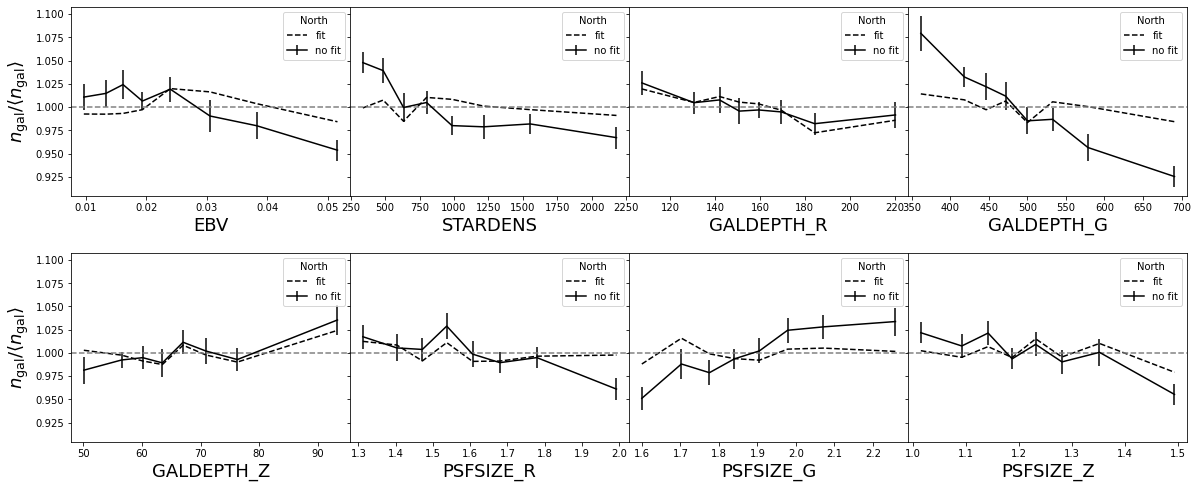

CPU times: user 1.41 s, sys: 308 ms, total: 1.71 s
Wall time: 1.54 s


In [13]:
%%time
#fg, ax = plt.subplots(ncols=4, nrows=2, figsize=(30, 12), sharey=True)
fg, ax = plt.subplots(ncols=4,nrows=2,sharey=True,figsize=(20,8))
#fig.subplots_adjust(hspace=0.4,wspace=0.2)
fg.subplots_adjust(wspace=0.0, hspace=0.3)
plt.rc('figure', facecolor='w')
ax = ax.flatten()
ftsize=18

for col_i in range(len(maps)):
    ax[col_i].set_xlabel(f'{maps[col_i]}',fontsize=ftsize)
    ax[col_i].errorbar(nnbar_list[col_i]['bin_avg'], nnbar_list[col_i]['nnbar'], nnbar_list[col_i]['nnbar_err'], color='k', label='no fit')
    ax[col_i].plot(nnbar_list_fit[col_i]['bin_avg'], nnbar_list_fit[col_i]['nnbar'], color='k',ls='--', label='fit')
    ax[col_i].legend(title=run.capitalize())
    ax[col_i].axhline(y=1., color='gray', ls='--')
ax[0].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)
ax[4].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)

#plt.tight_layout()
fn = os.path.join(plot_dir, f'ELG_{run}_density_variations.png')
#plt.savefig(fn, facecolor='white',bbox_inches='tight', pad_inches=0.1, dpi=200)

plt.show()

131.1396320642448
.............preparing randoms
cleaning randoms
preparing data
cleaning data
131.1396320642448
.............preparing randoms
cleaning randoms
preparing data
cleaning data


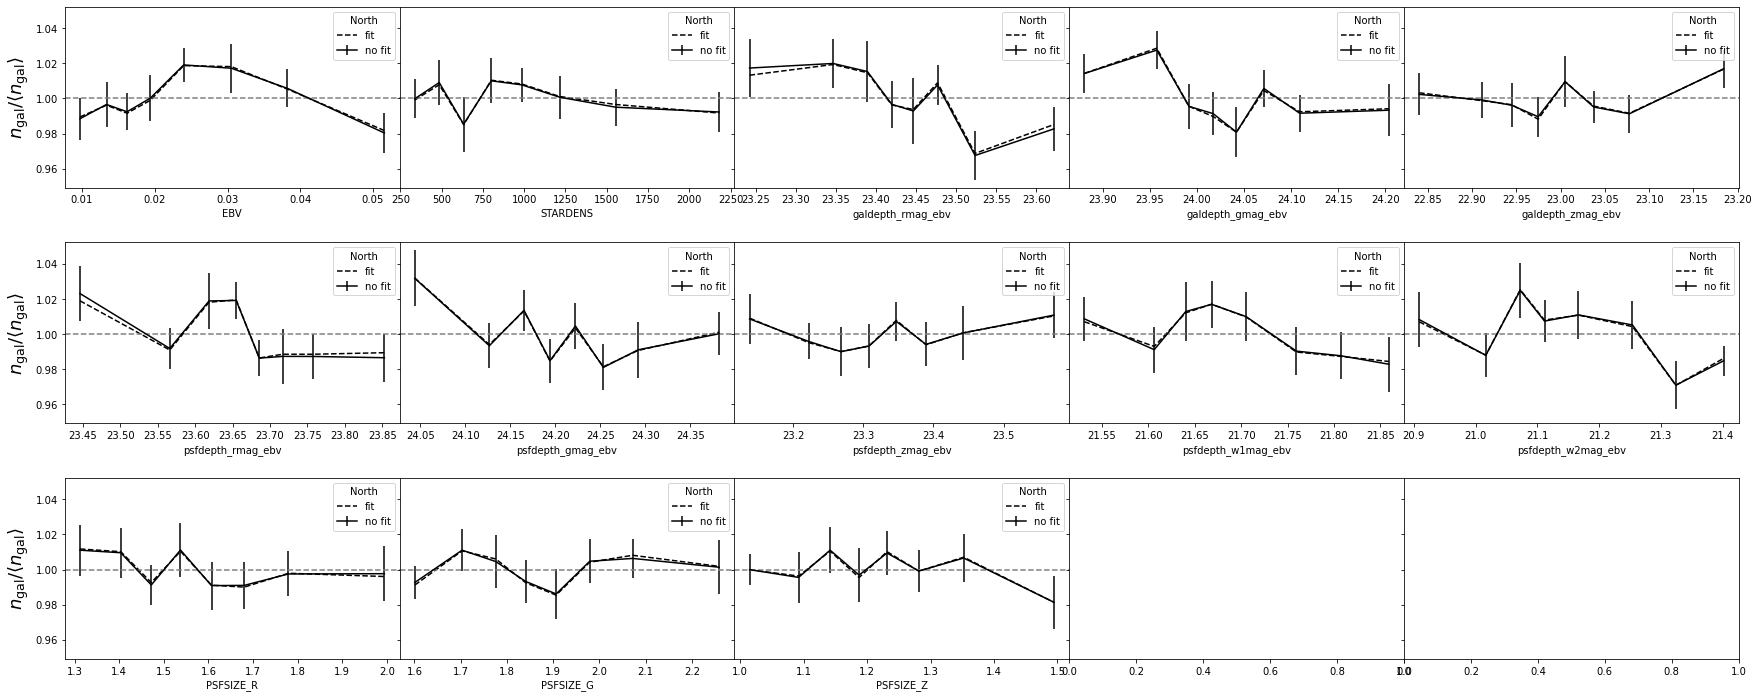

CPU times: user 8.32 s, sys: 1.05 s, total: 9.37 s
Wall time: 9.04 s


In [36]:
%%time
maps = maps_dr9
systematics = sys_region
hp_order = 'ring' # hpix ordering used in systematics file

prep_data = prepare_data(fit.cat, concat_rands, systematics, hp_order=hp_order, zmin=0.6, zmax=1.6, nside=256, columns=maps)
ngal = prep_data['label']
nran = prep_data['fracgood']
mask = np.ones_like(ngal, '?')
sysm = prep_data['features']
hpix = prep_data['hpix']

nnbar_list = get_meandensity(ngal, nran, mask, sysm, 
                             columns=maps, selection_fn=None, binning='equi-area', percentiles=[1, 99],
                             global_nbar=True, njack=20)


prep_data_fit = prepare_data(fit.cat, concat_rands, systematics, hp_order=hp_order, weights=fit.new_weights, zmin=0.6, zmax=1.6, nside=256, columns=maps)
ngal_fit = prep_data_fit['label']
nran_fit = prep_data_fit['fracgood']
mask_fit = np.ones_like(ngal_fit, '?')
sysm_fit = prep_data_fit['features']
hpix_fit = prep_data_fit['hpix']

nnbar_list_fit = get_meandensity(ngal_fit, nran_fit, mask_fit, sysm_fit, 
                                 columns=maps, selection_fn=None, binning='equi-area', percentiles=[1, 99],
                                 global_nbar=True, njack=20)

fg, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 12), sharey=True)
fg.subplots_adjust(wspace=0.0, hspace=0.3)
plt.rc('figure', facecolor='w')
ax = ax.flatten()
ftsize=18

for col_i in range(len(maps)):
    ax[col_i].set(xlabel=f'{maps[col_i]}')
    ax[col_i].errorbar(nnbar_list[col_i]['bin_avg'], nnbar_list[col_i]['nnbar'], nnbar_list[col_i]['nnbar_err'], color='k', label='no fit')
    ax[col_i].plot(nnbar_list_fit[col_i]['bin_avg'], nnbar_list_fit[col_i]['nnbar'], color='k',ls='--', label='fit')
    ax[col_i].legend(title=run.capitalize())
    ax[col_i].axhline(y=1., color='gray', ls='--')
ax[0].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)
ax[5].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)
ax[10].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)

fn = os.path.join(plot_dir, f'ELG_{run}_density_variations_rongpumaps.png')
#plt.savefig(fn, facecolor='white',bbox_inches='tight', pad_inches=0.1, dpi=200)

plt.show()

In [16]:
nnbar_list = get_meandensity(ngal, nran, mask, sysm, 
                             columns=maps_dr9, selection_fn=None, binning='equi-area', percentiles=[1, 99],
                             global_nbar=True, njack=20)

nnbar_list_fit = get_meandensity(ngal_fit, nran_fit, mask_fit, sysm_fit, 
                                 columns=maps_dr9, selection_fn=None, binning='equi-area', percentiles=[1, 99],
                                 global_nbar=True, njack=20)

#testing if plugging weights into selection_fn gives same as using ELGCat
hpix_test = radec2hpix(nside, fit.cat['RA'], fit.cat['DEC'])
pred_weights = make_hp(nside, hpix_test, fit.new_weights)[hpix]
nnbar_list_test = get_meandensity(ngal*pred_weights, nran, mask, sysm, 
                                 columns=maps_dr9, selection_fn=None, binning='equi-area', percentiles=[1, 99],
                                 global_nbar=True, njack=20)

# Power Spectrum

In [3]:
from pypower import CatalogFFTPower

# Set cosmology to transform redshift to distance
from cosmoprimo.fiducial import DESI
distance = DESI(engine='class').comoving_radial_distance  

def radec2hpix(nside, ra, dec):
    """ change ra,dec to HEALPix hpix with ring ordering """
    theta, phi = np.deg2rad(90.-dec), np.deg2rad(ra)
    hpix = hp.ang2pix(nside, theta, phi, nest=False)     
    return hpix

def project2hp(nside, mock, weight=None, return_hpix=False):
    """ count # of objects in HEALPix """
    ra = mock['RA']
    dec = mock['DEC']
    hpix = radec2hpix(nside, ra, dec)
    hpmap = np.bincount(hpix, weights=weight, minlength=12*nside*nside)
    if return_hpix:
        return hpmap, hpix
    else:
        return hpmap
    
def compute_power(data, randoms, data_weights=None, randoms_weights=None, ells=(0, 2, 4), edges=None, return_plot=False, nmesh=512):
    if edges is None:
        logger.info('Use default edges: np.linspace(0, 0.3, 81)')
        edges = np.linspace(0, 0.3, 81)
    
    # set data weights
    if data_weights is None:
        data_weights = np.ones(data['RA'].size)
    
    # set randoms weights
    if randoms_weights is None:
        randoms_weights = np.ones(randoms['RA'].size)
    
    result = CatalogFFTPower(data_positions1=[data['RA'], data['DEC'], distance(data['Z'])], data_weights1=data_weights,
                             randoms_positions1=[randoms['RA'], randoms['DEC'], distance(randoms['Z'])], randoms_weights1=randoms_weights,
                             edges=edges, ells=ells, interlacing=2, boxsize=None, boxpad=4, nmesh=nmesh, resampler='tsc',
                             los=None, position_type='rdd', mpiroot=0)
    if return_plot:
        return result.poles.k, result.poles
    
    
def compute_power_dir(base_dir, run, ells=(0), zmin=0.6, zmax=1.6, nmesh=256):
    # collect and mask data
    data_path = f'{base_dir}ELG_LOPnotqso_{run.capitalize()[0]}_clustering.dat.fits'
    data = ft.read(data_path)
    data = data[(data['Z'] < zmax) & (data['Z'] > zmin)]
    data_weights = data['WEIGHT']
    # collect randoms
    randoms_path = f"{base_dir}/ELG_LOPnotqso_{run.capitalize()[0]}_1_clustering.ran.fits"
    randoms = ft.read(randoms_path)
    randoms = randoms[(randoms['Z'] < zmax) & (randoms['Z'] > zmin)]
    randoms_weights = randoms['WEIGHT']
    
    k, poles = compute_power(data, randoms, ells=ells, data_weights=data_weights, randoms_weights=randoms_weights, return_plot=True)
    
    return k, poles

```
nside = 256
# collect randoms
randoms_path = f"/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/ELG_LOPnotqsozdone_{run.capitalize()[0]}_0_clustering.ran.fits"
randoms,h = ft.read(randoms_path, header=True)
randoms = randoms[(randoms['Z'] < 1.6) & (randoms['Z'] > 0.6)]


# project randoms to healpix ma
randoms_hmap, randoms_pix_number = project2hp(nside, randoms, return_hpix=True)
hp.mollview(randoms_hmap)
plt.show()

hp.mollview(project2hp(nside, test.cat))
plt.show()
```

In [4]:
run = 'south'
test = ELG_dndz(run=run)

[ 000031.06 ]: 10-19 13:48  Catalogue       INFO     Loading catalogue /global/cscratch1/sd/arosado/catalogs/DA02/LSS/guadalupe/LSScats/test/ELG_LOPnotqso_S_clustering.dat.fits.


min(dndz - 1): -0.5888101148780751, max(dndz - 1): 3.835820911047162
min(dndz - 1): -0.6152129530840917, max(dndz - 1): 3.847152474695214


[ 000479.70 ]: 10-19 13:55  DA02            INFO     Use default edges: np.linspace(0, 0.3, 81)
[ 000479.96 ]: 10-19 13:55  CatalogFFTPower INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[256 256 256], boxsize=[17884.51982576 17884.51982576 17884.51982576], boxcenter=[  -42.95987859 -1165.24871556   384.19005873], dtype=float64).
[ 000480.04 ]: 10-19 13:55  CatalogMesh     INFO     Slab 0 ~ 4194304 / 31925.
[ 000480.20 ]: 10-19 13:55  CatalogMesh     INFO     Painted 31925 out of 31925 objects to mesh.
[ 000480.20 ]: 10-19 13:55  CatalogMesh     INFO     Slab 0 ~ 4194304 / 221034.
[ 000480.45 ]: 10-19 13:55  CatalogMesh     INFO     Painted 221034 out of 221034 objects to mesh.
[ 000480.45 ]: 10-19 13:55  CatalogMesh     INFO     Running interlacing at order 2.
[ 000481.01 ]: 10-19 13:55  CatalogMesh     INFO     Slab 0 ~ 4194304 / 31925.
[ 000481.12 ]: 10-19 13:55  CatalogMesh     INFO     Painted 31925 out of 31925 objects to mesh.
[ 000481.12 ]: 10-19 13:55  CatalogMesh     I

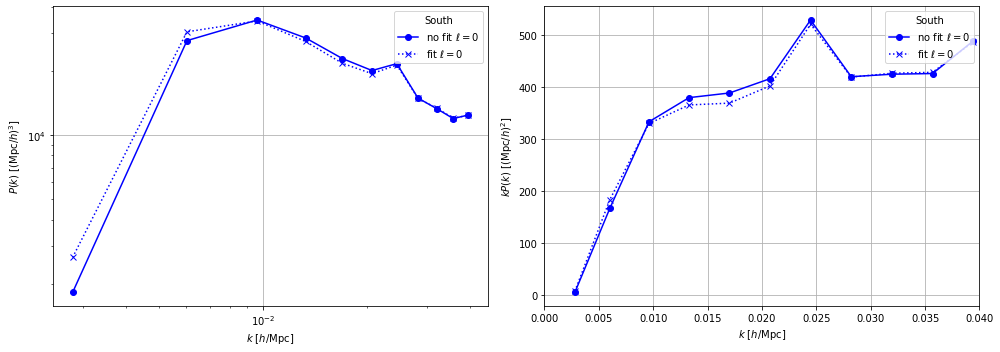

CPU times: user 15.1 s, sys: 4.71 s, total: 19.8 s
Wall time: 19.5 s


In [7]:
%%time 
regions = [run.capitalize()]
#test = ELG_dndz(run=run)
zmin, zmax = 0.8, 1.
mask = (test.cat['Z'] < zmax) & (test.cat['Z'] > zmin)
w = test.new_weights[mask]*test.weights_cat[mask]

# collect randoms
#randoms_path = f"/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/ELG_LOPnotqsozdone_{run.capitalize()[0]}_1_clustering.ran.fits"
randoms_path = f"/global/cscratch1/sd/arosado/catalogs/DA02/LSS/guadalupe/LSScats/test/ELG_LOPnotqso_{run.capitalize()[0]}_1_clustering.ran.fits"
randoms,h = ft.read(randoms_path, header=True)
randoms = randoms[(randoms['Z'] < zmax) & (randoms['Z'] > zmin)]
randoms_weights = randoms['WEIGHT']
#randoms_weights = randoms['WEIGHT_RF']*randoms['WEIGHT_FKP']*randoms['WEIGHT_COMP']
plt.figure(figsize=(14, 15/3))
fig = plt.gcf()
#fig.set_size_inches(5, 5)

j = 0
for region in regions:

    k, poles = compute_power(test.cat[mask], randoms, ells=(0), data_weights=test.weights_cat[mask], randoms_weights=randoms_weights, return_plot=True, nmesh=256)
    k2, poles2 = compute_power(test.cat[mask], randoms, ells=(0), data_weights=w, randoms_weights=randoms_weights, return_plot=True, nmesh=256)

    plt.subplot(121+j)
    j += 1
    #print(321+j)
    color = ['b', 'r', 'g']
    for i, ell in enumerate(poles.ells):
        plt.plot(k, poles(ell=ell, complex=False), marker='o', color=color[i], ls='-', label='no fit $\ell = {:d}$'.format(ell))
        plt.plot(k, poles2(ell=ell, complex=False), marker='x', color=color[i], ls=':', label='fit $\ell = {:d}$'.format(ell))
        #plt.plot(k, poles3(ell=ell, complex=False), marker='x', color=color[i], ls='--', label='cont (1/nn) $\ell = {:d}$'.format(ell))
    plt.legend(title=region, loc='upper right')
    plt.yscale('log')
    plt.xscale('log')
    #plt.ylim(1e4, 1e5)
    plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
    plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
    plt.grid(True)
    
    plt.subplot(121+j)
    j+=1
    color = ['b', 'r', 'g']
    for i, ell in enumerate(poles.ells):
        plt.plot(k, k*poles(ell=ell, complex=False), marker='o', color=color[i], ls='-', label='no fit $\ell = {:d}$'.format(ell))
        plt.plot(k, k*poles2(ell=ell, complex=False), marker='x', color=color[i], ls=':', label='fit $\ell = {:d}$'.format(ell))
        #plt.plot(k, k*poles3(ell=ell, complex=False), marker='x', color=color[i], ls='--', label='cont (1/nn) $\ell = {:d}$'.format(ell))
    plt.legend(title=region, loc='upper right')
    plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
    plt.ylabel(r'$kP(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
    plt.grid(True)
    plt.xlim(0,0.04)
    
plt.tight_layout()
fn = os.path.join(plot_dir, f'ELG_{run}_power.png')
#plt.savefig(fn, facecolor='white',dpi=200)
plt.show()

[ 000515.90 ]: 10-19 13:56  DA02            INFO     Use default edges: np.linspace(0, 0.3, 81)
[ 000515.97 ]: 10-19 13:56  CatalogFFTPower INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[256 256 256], boxsize=[15106.66660077 15106.66660077 15106.66660077], boxcenter=[ -33.84093738 -980.32428621  323.29623103], dtype=float64).
[ 000516.05 ]: 10-19 13:56  CatalogMesh     INFO     Slab 0 ~ 4194304 / 8898.
[ 000516.17 ]: 10-19 13:56  CatalogMesh     INFO     Painted 8898 out of 8898 objects to mesh.
[ 000516.17 ]: 10-19 13:56  CatalogMesh     INFO     Slab 0 ~ 4194304 / 61390.
[ 000516.30 ]: 10-19 13:56  CatalogMesh     INFO     Painted 61390 out of 61390 objects to mesh.
[ 000516.30 ]: 10-19 13:56  CatalogMesh     INFO     Running interlacing at order 2.
[ 000516.84 ]: 10-19 13:56  CatalogMesh     INFO     Slab 0 ~ 4194304 / 8898.
[ 000516.94 ]: 10-19 13:56  CatalogMesh     INFO     Painted 8898 out of 8898 objects to mesh.
[ 000516.94 ]: 10-19 13:56  CatalogMesh     INFO     Slab

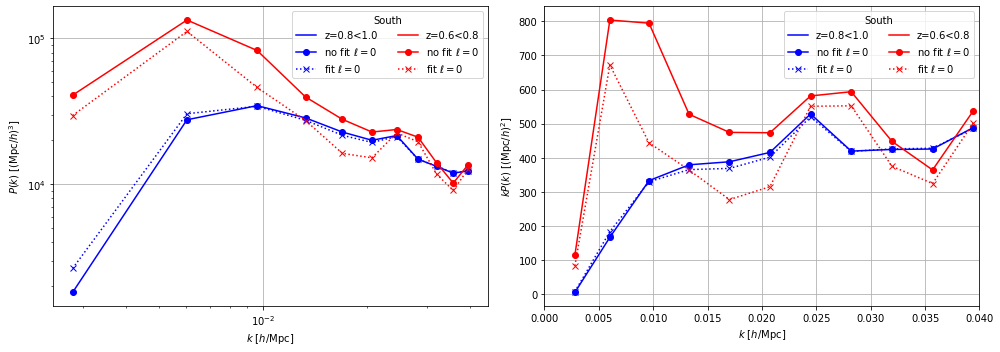

CPU times: user 13 s, sys: 3.19 s, total: 16.2 s
Wall time: 15.9 s


In [8]:
%%time 
regions = [run.capitalize()]
#test = ELG_dndz(run=run)
zmin, zmax = 0.6, 0.8
mask = (test.cat['Z'] < zmax) & (test.cat['Z'] > zmin)
w = test.new_weights[mask]*test.weights_cat[mask]

# collect randoms
#randoms_path = f"/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/ELG_LOPnotqsozdone_{run.capitalize()[0]}_1_clustering.ran.fits"
randoms_path = f"/global/cscratch1/sd/arosado/catalogs/DA02/LSS/guadalupe/LSScats/test/ELG_LOPnotqso_{run.capitalize()[0]}_1_clustering.ran.fits"
randoms,h = ft.read(randoms_path, header=True)
randoms = randoms[(randoms['Z'] < zmax) & (randoms['Z'] > zmin)]
randoms_weights = randoms['WEIGHT']
#randoms_weights = randoms['WEIGHT_RF']*randoms['WEIGHT_FKP']*randoms['WEIGHT_COMP']
plt.figure(figsize=(14, 15/3))
fig = plt.gcf()
#fig.set_size_inches(5, 5)

j = 0
for region in regions:

    k3, poles3 = compute_power(test.cat[mask], randoms, ells=(0), data_weights=test.weights_cat[mask], randoms_weights=randoms_weights, return_plot=True, nmesh=256)
    k4, poles4 = compute_power(test.cat[mask], randoms, ells=(0), data_weights=w, randoms_weights=randoms_weights, return_plot=True, nmesh=256)

    plt.subplot(121+j)
    j += 1
    #print(321+j)
    color = ['b', 'r', 'g']
    for i, ell in enumerate(poles.ells):
        plt.plot([],[],color=color[0], label='z=0.8<1.0')
        plt.plot(k, poles(ell=ell, complex=False), marker='o', color=color[0], ls='-', label='no fit $\ell = {:d}$'.format(ell))
        plt.plot(k, poles2(ell=ell, complex=False), marker='x', color=color[0], ls=':', label='fit $\ell = {:d}$'.format(ell))
        plt.plot([],[],color=color[1], label='z=0.6<0.8')
        plt.plot(k, poles3(ell=ell, complex=False), marker='o', color=color[1], ls='-', label='no fit $\ell = {:d}$'.format(ell))
        plt.plot(k, poles4(ell=ell, complex=False), marker='x', color=color[1], ls=':', label='fit $\ell = {:d}$'.format(ell))
        #plt.plot(k, poles3(ell=ell, complex=False), marker='x', color=color[i], ls='--', label='cont (1/nn) $\ell = {:d}$'.format(ell))
    plt.legend(title=region, loc='upper right', ncol=2)
    plt.yscale('log')
    plt.xscale('log')
    #plt.ylim(1e4, 1e5)
    plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
    plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
    plt.grid(True)
    
    plt.subplot(121+j)
    j+=1
    color = ['b', 'r', 'g']
    for i, ell in enumerate(poles.ells):
        plt.plot([],[],color=color[0], label='z=0.8<1.0')
        plt.plot(k, k*poles(ell=ell, complex=False), marker='o', color=color[0], ls='-', label='no fit $\ell = {:d}$'.format(ell))
        plt.plot(k, k*poles2(ell=ell, complex=False), marker='x', color=color[0], ls=':', label='fit $\ell = {:d}$'.format(ell))
        plt.plot([],[],color=color[1], label='z=0.6<0.8')
        plt.plot(k, k*poles3(ell=ell, complex=False), marker='o', color=color[1], ls='-', label='no fit $\ell = {:d}$'.format(ell))
        plt.plot(k, k*poles4(ell=ell, complex=False), marker='x', color=color[1], ls=':', label='fit $\ell = {:d}$'.format(ell))
        #plt.plot(k, k*poles3(ell=ell, complex=False), marker='x', color=color[i], ls='--', label='cont (1/nn) $\ell = {:d}$'.format(ell))
    plt.legend(title=region, loc='upper right', ncol=2)
    plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
    plt.ylabel(r'$kP(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
    plt.grid(True)
    plt.xlim(0,0.04)
    
plt.tight_layout()
fn = os.path.join(plot_dir, f'ELG_{run}_power.png')
#plt.savefig(fn, facecolor='white',dpi=200)
plt.show()

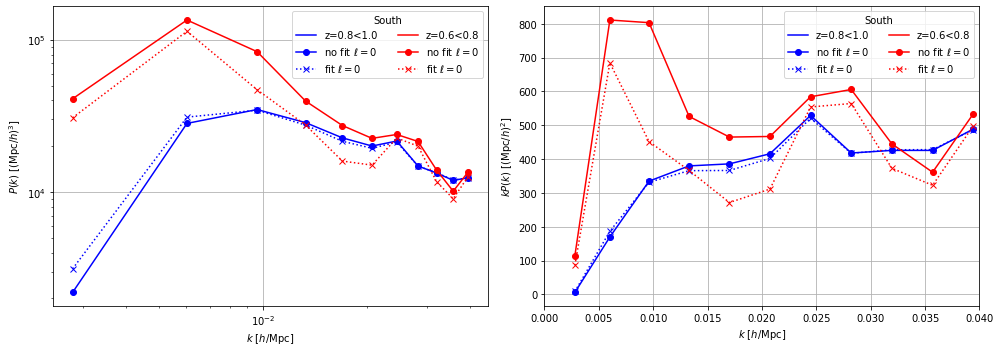

CPU times: user 1.26 s, sys: 287 ms, total: 1.54 s
Wall time: 1.31 s


In [19]:
%%time 
regions = [run.capitalize()]
#test = ELG_dndz(run=run)
zmin, zmax = 0.6, 0.8
mask = (test.cat['Z'] < zmax) & (test.cat['Z'] > zmin)
w = test.new_weights[mask]*test.weights_cat[mask]

# collect randoms
#randoms_path = f"/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/ELG_LOPnotqsozdone_{run.capitalize()[0]}_1_clustering.ran.fits"
randoms_path = f"/global/cscratch1/sd/arosado/catalogs/DA02/LSS/guadalupe/LSScats/test/ELG_LOPnotqso_{run.capitalize()[0]}_1_clustering.ran.fits"
randoms,h = ft.read(randoms_path, header=True)
randoms = randoms[(randoms['Z'] < zmax) & (randoms['Z'] > zmin)]
randoms_weights = randoms['WEIGHT']
#randoms_weights = randoms['WEIGHT_RF']*randoms['WEIGHT_FKP']*randoms['WEIGHT_COMP']
plt.figure(figsize=(14, 15/3))
fig = plt.gcf()
#fig.set_size_inches(5, 5)

j = 0
for region in regions:

    k3, poles3 = compute_power(test.cat[mask], randoms, ells=(0), data_weights=test.weights_cat[mask], randoms_weights=randoms_weights, return_plot=True, nmesh=256)
    k4, poles4 = compute_power(test.cat[mask], randoms, ells=(0), data_weights=w, randoms_weights=randoms_weights, return_plot=True, nmesh=256)

    plt.subplot(121+j)
    j += 1
    #print(321+j)
    color = ['b', 'r', 'g']
    for i, ell in enumerate(poles.ells):
        plt.plot([],[],color=color[0], label='z=0.8<1.0')
        plt.plot(k, poles(ell=ell, complex=False), marker='o', color=color[0], ls='-', label='no fit $\ell = {:d}$'.format(ell))
        plt.plot(k, poles2(ell=ell, complex=False), marker='x', color=color[0], ls=':', label='fit $\ell = {:d}$'.format(ell))
        plt.plot([],[],color=color[1], label='z=0.6<0.8')
        plt.plot(k, poles3(ell=ell, complex=False), marker='o', color=color[1], ls='-', label='no fit $\ell = {:d}$'.format(ell))
        plt.plot(k, poles4(ell=ell, complex=False), marker='x', color=color[1], ls=':', label='fit $\ell = {:d}$'.format(ell))
        #plt.plot(k, poles3(ell=ell, complex=False), marker='x', color=color[i], ls='--', label='cont (1/nn) $\ell = {:d}$'.format(ell))
    plt.legend(title=region, loc='upper right', ncol=2)
    plt.yscale('log')
    plt.xscale('log')
    #plt.ylim(1e4, 1e5)
    plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
    plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
    plt.grid(True)
    
    plt.subplot(121+j)
    j+=1
    color = ['b', 'r', 'g']
    for i, ell in enumerate(poles.ells):
        plt.plot([],[],color=color[0], label='z=0.8<1.0')
        plt.plot(k, k*poles(ell=ell, complex=False), marker='o', color=color[0], ls='-', label='no fit $\ell = {:d}$'.format(ell))
        plt.plot(k, k*poles2(ell=ell, complex=False), marker='x', color=color[0], ls=':', label='fit $\ell = {:d}$'.format(ell))
        plt.plot([],[],color=color[1], label='z=0.6<0.8')
        plt.plot(k, k*poles3(ell=ell, complex=False), marker='o', color=color[1], ls='-', label='no fit $\ell = {:d}$'.format(ell))
        plt.plot(k, k*poles4(ell=ell, complex=False), marker='x', color=color[1], ls=':', label='fit $\ell = {:d}$'.format(ell))
        #plt.plot(k, k*poles3(ell=ell, complex=False), marker='x', color=color[i], ls='--', label='cont (1/nn) $\ell = {:d}$'.format(ell))
    plt.legend(title=region, loc='upper right', ncol=2)
    plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
    plt.ylabel(r'$kP(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
    plt.grid(True)
    plt.xlim(0,0.04)
    
plt.tight_layout()
fn = os.path.join(plot_dir, f'ELG_{run}_power.png')
#plt.savefig(fn, facecolor='white',dpi=200)
plt.show()

[ 000073.09 ]: 10-19 08:48  DA02            INFO     Use default edges: np.linspace(0, 0.3, 81)
[ 000073.32 ]: 10-19 08:48  CatalogFFTPower INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[512 512 512], boxsize=[17915.93753843 17915.93753843 17915.93753843], boxcenter=[  -39.03266451 -1168.57153348   385.71195815], dtype=float64).
[ 000073.98 ]: 10-19 08:48  CatalogMesh     INFO     Slab 0 ~ 4194304 / 31925.
[ 000074.10 ]: 10-19 08:48  CatalogMesh     INFO     Painted 31925 out of 31925 objects to mesh.
[ 000074.11 ]: 10-19 08:48  CatalogMesh     INFO     Slab 0 ~ 4194304 / 237314.
[ 000074.34 ]: 10-19 08:48  CatalogMesh     INFO     Painted 237314 out of 237314 objects to mesh.
[ 000074.34 ]: 10-19 08:48  CatalogMesh     INFO     Running interlacing at order 2.
[ 000078.91 ]: 10-19 08:48  CatalogMesh     INFO     Slab 0 ~ 4194304 / 31925.
[ 000079.00 ]: 10-19 08:48  CatalogMesh     INFO     Painted 31925 out of 31925 objects to mesh.
[ 000079.00 ]: 10-19 08:48  CatalogMesh     I

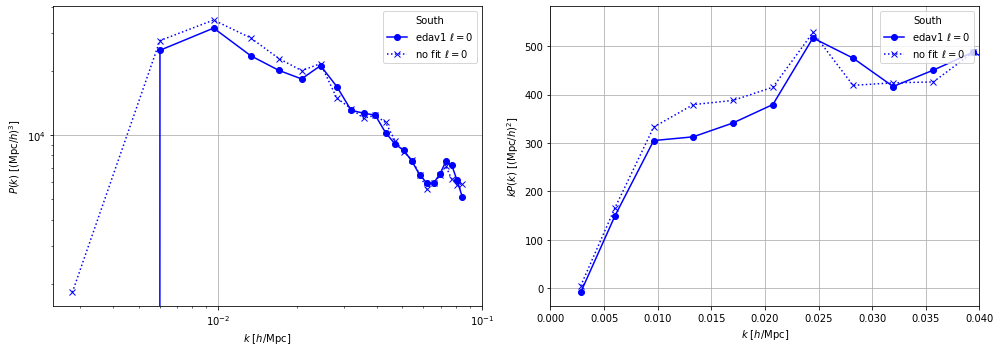

CPU times: user 1min 9s, sys: 11.1 s, total: 1min 21s
Wall time: 1min 20s


In [5]:
%%time 
run = 'south'
regions = [run.capitalize()]
#test = ELG_dndz(run=run)
zmin, zmax = 0.8, 1.

edav_dir = f'/global/cfs/cdirs/desi/survey/catalogs/edav1/da02/LSScats/clustering/'
test_dir = '/global/cscratch1/sd/arosado/catalogs/DA02/LSS/guadalupe/LSScats/test/'

plt.figure(figsize=(14, 15/3))
fig = plt.gcf()
#fig.set_size_inches(5, 5)

j = 0
for region in regions:

    k, poles = compute_power_dir(edav_dir, run, ells=(0), zmin=zmin, zmax=zmax, nmesh=256)
    k2, poles2 = compute_power_dir(test_dir, run, ells=(0), zmin=zmin, zmax=zmax, nmesh=256)
    
    plt.subplot(121+j)
    j += 1
    #print(321+j)
    color = ['b', 'r', 'g']
    for i, ell in enumerate(poles.ells):
        plt.plot(k, poles(ell=ell, complex=False), marker='o', color=color[i], ls='-', label='edav1 $\ell = {:d}$'.format(ell))
        plt.plot(k2, poles2(ell=ell, complex=False), marker='x', color=color[i], ls=':', label='no fit $\ell = {:d}$'.format(ell))
    plt.legend(title=region, loc='upper right')
    plt.yscale('log')
    plt.xscale('log')
    #plt.ylim(1e4, 1e5)
    plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
    plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
    plt.grid(True)
    
    plt.subplot(121+j)
    j+=1
    color = ['b', 'r', 'g']
    for i, ell in enumerate(poles.ells):
        plt.plot(k, k*poles(ell=ell, complex=False), marker='o', color=color[i], ls='-', label='edav1 $\ell = {:d}$'.format(ell))
        plt.plot(k, k*poles2(ell=ell, complex=False), marker='x', color=color[i], ls=':', label='no fit $\ell = {:d}$'.format(ell))
    plt.legend(title=region, loc='upper right')
    plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
    plt.ylabel(r'$kP(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
    plt.grid(True)
    plt.xlim(0,0.04)
    
plt.tight_layout()
fn = os.path.join(plot_dir, f'ELG_{run}_power.png')
#plt.savefig(fn, facecolor='white',dpi=200)
plt.show()

# Angular Correlation Function

In [3]:
from pycorr import TwoPointCorrelationFunction, LandySzalayTwoPointEstimator, KMeansSubsampler

In [4]:
def get_ra_dec(nside):
    ra, dec = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), nest=False, lonlat=True)
    return ra, dec

def radec2hpix(nside, ra, dec):
    """ change ra,dec to HEALPix hpix with ring ordering """
    theta, phi = np.deg2rad(90.-dec), np.deg2rad(ra)
    hpix = hp.ang2pix(nside, theta, phi, nest=False)     
    return hpix

def project2hp(nside, mock, weight=None, return_hpix=False):
    """ count # of objects in HEALPix """
    ra = mock['RA']
    dec = mock['DEC']
    hpix = radec2hpix(nside, ra, dec)
    hpmap = np.bincount(hpix, weights=weight, minlength=12*nside*nside)
    if return_hpix:
        return hpmap, hpix
    else:
        return hpmap
    
def make_hp(nside, hpix, value, fill_nan=False):
    """ 
        Create a healpix map given nside, hpix, and value
        
    """
    map_ = np.zeros(12*nside*nside)
    if fill_nan:
        map_[:] = np.nan
    
    map_[hpix] = value
    return map_
    
def compute_theoritical_error(result):
    Gp = result.R1R2.normalized_wcounts()
    ND = result.D1D2.positions1[0].size
    xi_v = np.nansum(Gp*result.corr) # le 
    d = (result.corr + 1.) / (xi_v + 1.) # eq. 48
    p = 2./(Gp * ND * (ND - 1)) # eq. 43
    return d * p**0.5

def compute_angular_correlation(pix_data, pix_randoms, ra_pix, dec_pix, pix_selected, suffixe, 
                                sys_weight_map=None, edges=None, n_jackkniffe=20,
                                return_result=False, return_plot=False, save_result=False):
    """
    Remark: 
        * Error estimation with Jackknife increase the computation speed (TwoPointCorrelationFunction step) by a factor higher than ~2.
        * In the case of Target LRG in DES n_jackknife = 5 give already correct estimation of the error ! (obvisouly n_jackknife will depends on the region)
    """
    if edges is None:
        logger.info('Use default edges: np.geomspace(1e-1, 10, 25)')
        edges = np.geomspace(1e-1, 10, 25)
        
    if sys_weight_map is not None:
        logger.info('Apply systematic weights')
        pix_data_weight = pix_data*sys_weight_map
    else:
        pix_data_weight = pix_data
        
    if n_jackkniffe is not None:
        # for the Jackniffe errors: Initialize KMeansSubsampler with data or random positions -> should have no impact.
        subsampler = KMeansSubsampler(mode='angular', positions=[ra_pix[pix_selected], dec_pix[pix_selected]], nsamples=n_jackkniffe, nside=512, random_state=42, position_type='rd')
        data_labels = randoms_labels = subsampler.label([ra_pix[pix_selected], dec_pix[pix_selected]])
    else:
        data_labels = randoms_labels = None
        
    import time
    start = time.time()    
    result = TwoPointCorrelationFunction('theta', edges, 
                                         data_positions1=[ra_pix[pix_selected], dec_pix[pix_selected]], 
                                         data_weights1=pix_data_weight[pix_selected], 
                                         data_samples1=data_labels,
                                         randoms_positions1=[ra_pix[pix_selected], dec_pix[pix_selected]], 
                                         randoms_weights1=pix_randoms[pix_selected], 
                                         randoms_samples1=randoms_labels,
                                         engine='corrfunc', isa='fastest', nthreads=48)
    logger.info(f"It takes: {time.time()-start}")
    
    if save_result:
        output = f'PYCORR/ELG_{suffixe}.npy'
        result.save(output)
    
    if return_result:
        return result
    
    if return_plot:
        if n_jackkniffe is None:
            return result.sep, result.corr, compute_theoritical_error(result)
        else: 
            return result.sep, result.corr, np.diag(result.cov())**0.5

In [7]:
%%time 
nside=256
run = 'south'
regions = [run.capitalize()]
fit = ELG_dndz(run=run)
data_hmap, data_pix_number = project2hp(nside, fit.cat, return_hpix=True)
mask = make_hp(nside, data_pix_number, 1.0) > 0.5

# build ra, dec position for each pixel
ra_pix, dec_pix = get_ra_dec(nside)

# collect randoms
randoms_path = f"/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/ELG_LOPnotqsozdone_{run.capitalize()[0]}_1_clustering.ran.fits"
randoms,h = ft.read(randoms_path, header=True)
randoms = randoms[(randoms['Z'] < 1.6) & (randoms['Z'] > 0.6)]
randoms_hmap, randoms_pix_number = project2hp(nside, randoms, return_hpix=True)



min(dndz - 1): -0.5888101148780751, max(dndz - 1): 3.835820911047162
min(dndz - 1): -0.6152129530840917, max(dndz - 1): 3.847152474695214
CPU times: user 7.93 s, sys: 1.6 s, total: 9.53 s
Wall time: 9.5 s


[ 000008.41 ]: 10-06 12:02  DA02            INFO     Use default edges: np.geomspace(1e-1, 10, 25)
[ 000009.72 ]: 10-06 12:02  TwoPointCorrelationFunction INFO     Using estimator <class 'pycorr.twopoint_jackknife.JackknifeLandySzalayTwoPointEstimator'>.
[ 000009.72 ]: 10-06 12:02  TwoPointCorrelationFunction INFO     Computing two-point counts D1D2.
/global/homes/a/arosado/.conda/envs/regressis/lib/python3.8/site-packages/Corrfunc/utils.py:1115: UserWarning: Warning: Cray hugepages has a bug that may crash Corrfunc. You might be able to fix such a crash with `module unload craype-hugepages2M` (see https://github.com/manodeep/Corrfunc/issues/245 for details)
  warnings.warn('Warning: Cray hugepages has a bug that may crash '
[ 000012.40 ]: 10-06 12:02  TwoPointCorrelationFunction INFO     Computing two-point counts D1R2.
[ 000014.60 ]: 10-06 12:02  TwoPointCorrelationFunction INFO     Computing two-point counts R1R2.
[ 000015.91 ]: 10-06 12:02  DA02            INFO     It takes: 6.1916

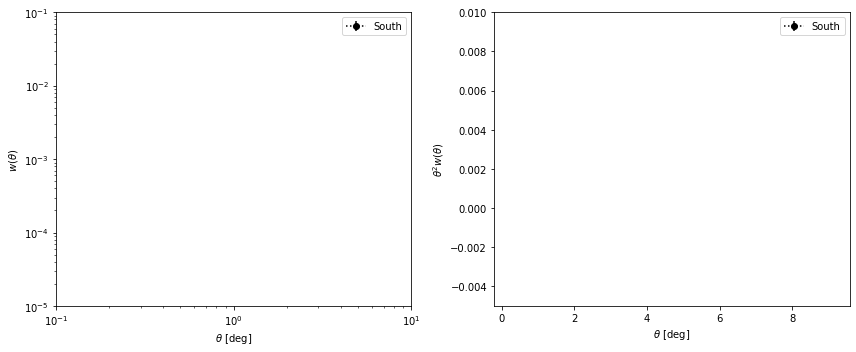

In [11]:
for i, region in enumerate(regions):
    theta, w, err_w = compute_angular_correlation(data_hmap, randoms_hmap, ra_pix, dec_pix, mask, region, sys_weight_map=None, return_plot=True)
    ax = axs[0]
    ax.errorbar(theta, w, err_w, marker='o', ls=':', c='black', label=region)
    ax = axs[1]
    ax.errorbar(theta, theta**2*w, theta**2*err_w, marker='o', ls=':', c='black', label=region)  

    
    ax = axs[0]
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-1, 1e1)
    ax.set_ylim(1e-5, 1e-1)
    ax.set_xlabel(r'$\theta$ [deg]')
    ax.set_ylabel(r'$w(\theta)$')
    ax.legend()

    ax = axs[1]
    ax.set_ylim(-0.005, 0.01)
    ax.set_xlabel(r'$\theta$ [deg]')
    ax.set_ylabel(r'$\theta^2 w(\theta)$')
    ax.legend()

    fig.tight_layout()

plt.show()